In [45]:
#pip install opencv-python
#pip install imghdr
#pip install tensorflow


In [46]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import os
import cv2
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import imghdr

In [47]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [48]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [49]:
data_dir = 'Train' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [50]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

In [51]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

In [52]:
def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)

  # img = tf.image.decode_image(img, channels=IMG_CHANNELS, expand_animations=False)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img = tf.resize_images_v2(img, reshape_dims, method="bilinear")
  # return img.set_shape((image_size[0], image_size[1], num_channels))

  # Resize the image to the desired size.
  img = tf.image.resize(img, reshape_dims) #[244,244] using image module for resizing,
  #must also apply on testing and validation dataset
  return img

  ##add prediction and preprocessing

#change regex pattern from PetImages\\ to PetImages/
pattern = r'train/'
print(tf.io.gfile.glob("train/*"))
CLASS_NAMES = [item.numpy().decode("utf-8") for item in
               tf.strings.regex_replace(
                 tf.io.gfile.glob("train/*"),
                 pattern, "")]

print(CLASS_NAMES)
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]

print("These are the available classes:", CLASS_NAMES)

['train\\Jacket', 'train\\LongPants', 'train\\Sandals', 'train\\Shoes', 'train\\ShortPants', 'train\\TShirt']
['train\\Jacket', 'train\\LongPants', 'train\\Sandals', 'train\\Shoes', 'train\\ShortPants', 'train\\TShirt']
These are the available classes: ['train\\Jacket', 'train\\LongPants', 'train\\Sandals', 'train\\Shoes', 'train\\ShortPants', 'train\\TShirt']


['train\\Jacket\\-1x-1.jpg', 'train\\Jacket\\04391708526-a3.jpg', 'train\\Jacket\\0584011ccd0a0ab3b4d80638bf76ee61.jpg', 'train\\Jacket\\119368-BLK00-front.jpg', 'train\\Jacket\\119598-REFP0-front.jpg', 'train\\Jacket\\1629717737612384e9619ceYDS_Product_42x.jpg', 'train\\Jacket\\1_7d097a2f-a15a-4674-93ce-a06c1af49cf1.jpg', 'train\\Jacket\\230117-puffer-jacket-bd-2x1.jpg', 'train\\Jacket\\240301-plp-jackets-m-m.jpg', 'train\\Jacket\\26_223-6013-L_2776_ca3c4dae-f3fb-469e-90e7-a2e948c2980a_1024x.jpg', 'train\\Jacket\\430102-9399-201034-2-zoom.jpg', 'train\\Jacket\\433377126_max.jpg', 'train\\Jacket\\51KjY0T1U6L._AC_UY1100_.jpg', 'train\\Jacket\\51Re8qRfcYL._AC_UY1100_.jpg', 'train\\Jacket\\65380ba9e86ef865334fcb14-men-denim-jacket-streetwear-hip-hop.jpg', 'train\\Jacket\\71oEH14QJL._AC_UY1100_.jpg', 'train\\Jacket\\784x1000_58721_b094815d736ffcf1476708893cc63a74_16300825091500Zachjacketgrey.jpg', 'train\\Jacket\\8809947343001_01_JPG_540x.jpg', 'train\\Jacket\\Adicolor_VRCT_Jacket_Green_IJ

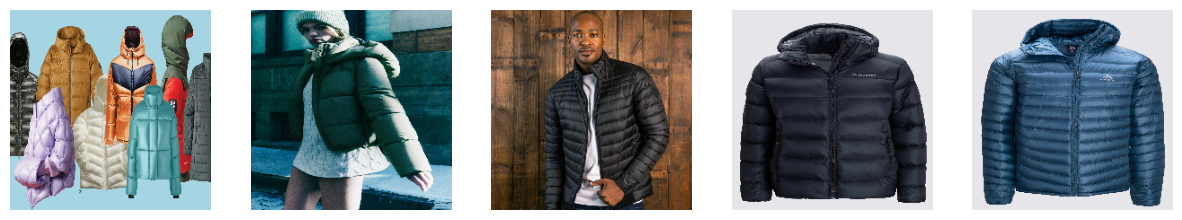

In [53]:
cloth = tf.io.gfile.glob("train/Jacket/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
print(cloth)
for idx, filename in enumerate(cloth[:5]):
  print(filename)
  print(idx)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('off')

In [54]:
df = pd.DataFrame(columns=['path', 'class'])
absolutePath = r"Train/"

# Get a list of class subdirectories within the absolute path
class_dirs = [d for d in os.listdir(absolutePath) if os.path.isdir(os.path.join(absolutePath, d))]

for class_dir in class_dirs:
  class_path = os.path.join(absolutePath, class_dir)

  # Find image files within the class directory using a glob pattern
  image_paths = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg'))]

  paths_df = pd.DataFrame({'path': image_paths})
  paths_df['class'] = class_dir

  df = pd.concat([df, paths_df], ignore_index=True)

print(df)

                                                  path   class
0                               Train/Jacket\-1x-1.jpg  Jacket
1                      Train/Jacket\04391708526-a3.jpg  Jacket
2    Train/Jacket\0584011ccd0a0ab3b4d80638bf76ee61.jpg  Jacket
3                  Train/Jacket\119368-BLK00-front.jpg  Jacket
4                  Train/Jacket\119598-REFP0-front.jpg  Jacket
..                                                 ...     ...
887               Train/TShirt\TS6580UOY13_BG2_001.jpg  TShirt
888  Train/TShirt\TSCO_5000_Essential_Heavy_Tee_bla...  TShirt
889                        Train/TShirt\Tshirts_HP.jpg  TShirt
890                   Train/TShirt\white-t-shirt-2.jpg  TShirt
891    Train/TShirt\whitetshirts-2048px-0297-2x1-1.jpg  TShirt

[892 rows x 2 columns]


In [55]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(df["path"], df["class"], test_size=0.20)

# Create DataFrames from the split data
X_train_df = pd.DataFrame(X_train, columns=["path"])
X_test_df = pd.DataFrame(X_test, columns=["path"])

# Concatenate paths and labels for training and testing data
trainData = pd.concat([X_train_df, y_train], axis=1)
testData = pd.concat([X_test_df, y_test], axis=1)

trainData.to_csv("train.csv",index=False, header=False)
testData.to_csv("test.csv",index=False, header=False)
print(trainData)

                                                  path       class
882  Train/TShirt\Select-The-Best-From-This-Stellar...      TShirt
447          Train/Sandals\India_Beige_4_1024x1024.jpg     Sandals
226  Train/LongPants\fea8f1073054d0c8f4e822975c1a60...   LongPants
160                           Train/Jacket\images8.jpg      Jacket
581    Train/Shoes\running-shoes-2048px-3128-2x1-1.jpg       Shoes
..                                                 ...         ...
420                         Train/Sandals\image44.jpeg     Sandals
856                           Train/TShirt\image9.jpeg      TShirt
156                          Train/Jacket\images59.jpg      Jacket
721  Train/ShortPants\men-summer-short-pants-500x50...  ShortPants
543                           Train/Shoes\image35.jpeg       Shoes

[713 rows x 2 columns]


In [56]:
def decode_csv(csv_row):
  record_defaults = ["path", "class"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [62]:
train_dataset = (tf.data.TextLineDataset(
    "train.csv").
    map(decode_csv)).batch(3)

eval_dataset = (tf.data.TextLineDataset(
    "test.csv").
    map(decode_csv)).batch(3)

print(train_dataset)
print(eval_dataset)


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


PREPROCESSING

In [63]:
# linear model
model = ResNet50(weights='imagenet', include_top=False)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

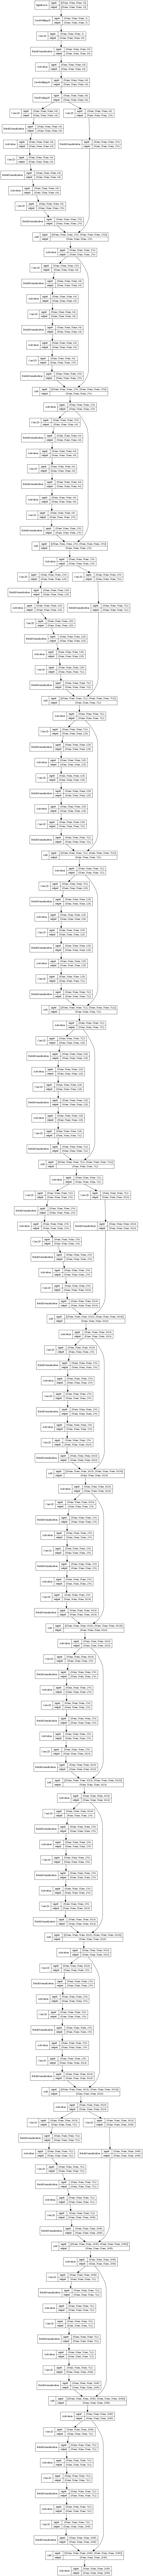

In [60]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [65]:
history = model.fit(train_dataset, validation_data=eval_dataset)

InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\AkYamin\AppData\Local\Temp\ipykernel_19496\2162460833.py", line 1, in <module>
      history = model.fit(train_dataset, validation_data=eval_dataset)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\metrics\base_metric.py", line 700, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\metrics\metrics.py", line 3669, in sparse_categorical_accuracy
      matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "c:\Users\AkYamin\miniconda3\envs\py310\lib\site-packages\keras\utils\metrics_utils.py", line 970, in sparse_categorical_matches
      matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal'
required broadcastable shapes
	 [[{{node Equal}}]] [Op:__inference_train_function_53810]

In [ ]:
plt.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed')
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

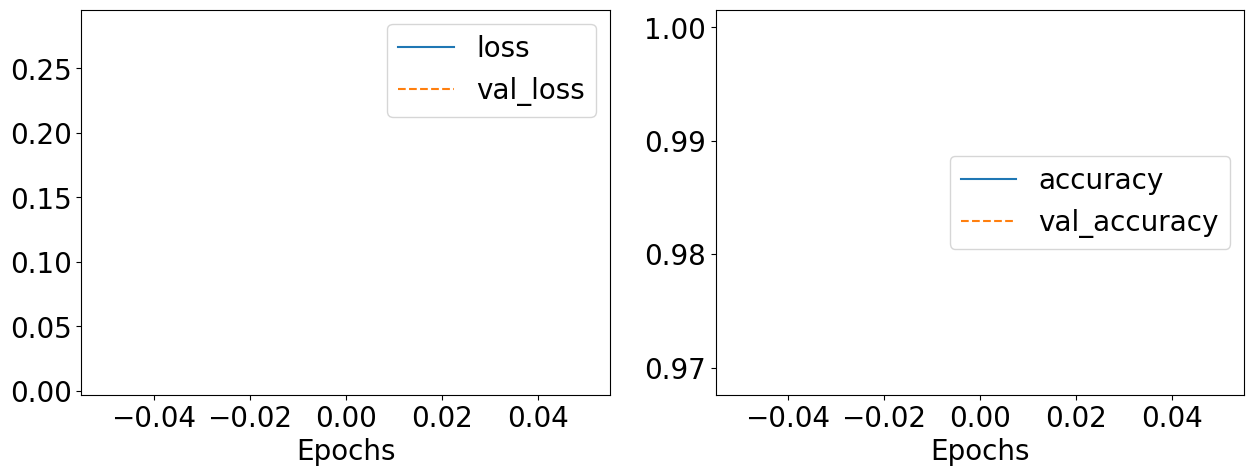

In [ ]:
training_plot(['loss', 'accuracy'], history)

[0.09405971 0.0570501  0.8488902 ]
[0.04838872 0.0721875  0.8794238 ]


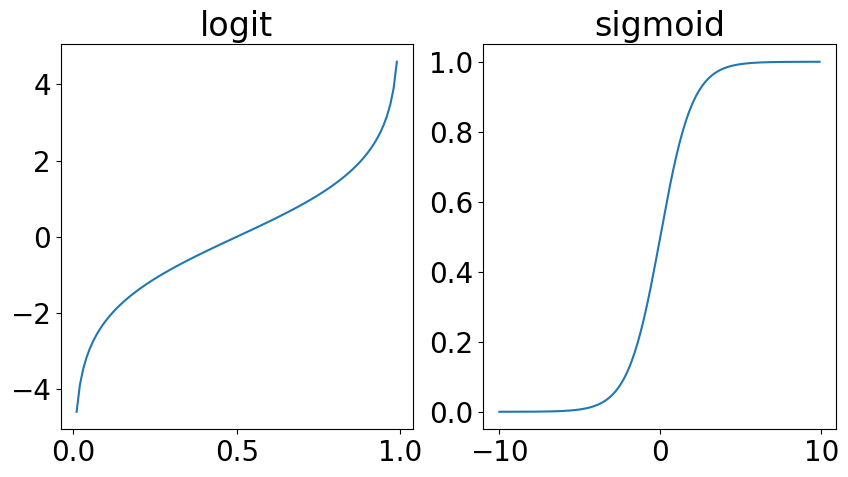

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title("logit")
x = np.arange(-10.0, 10.0, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y)
ax[1].set_title("sigmoid")

print( tf.math.softmax([-1.0, -1.5, 1.2]).numpy() )
print( tf.math.softmax([0.1, 0.5, 3.0]).numpy() )

1/1 [==============================] - 0s 27ms/step


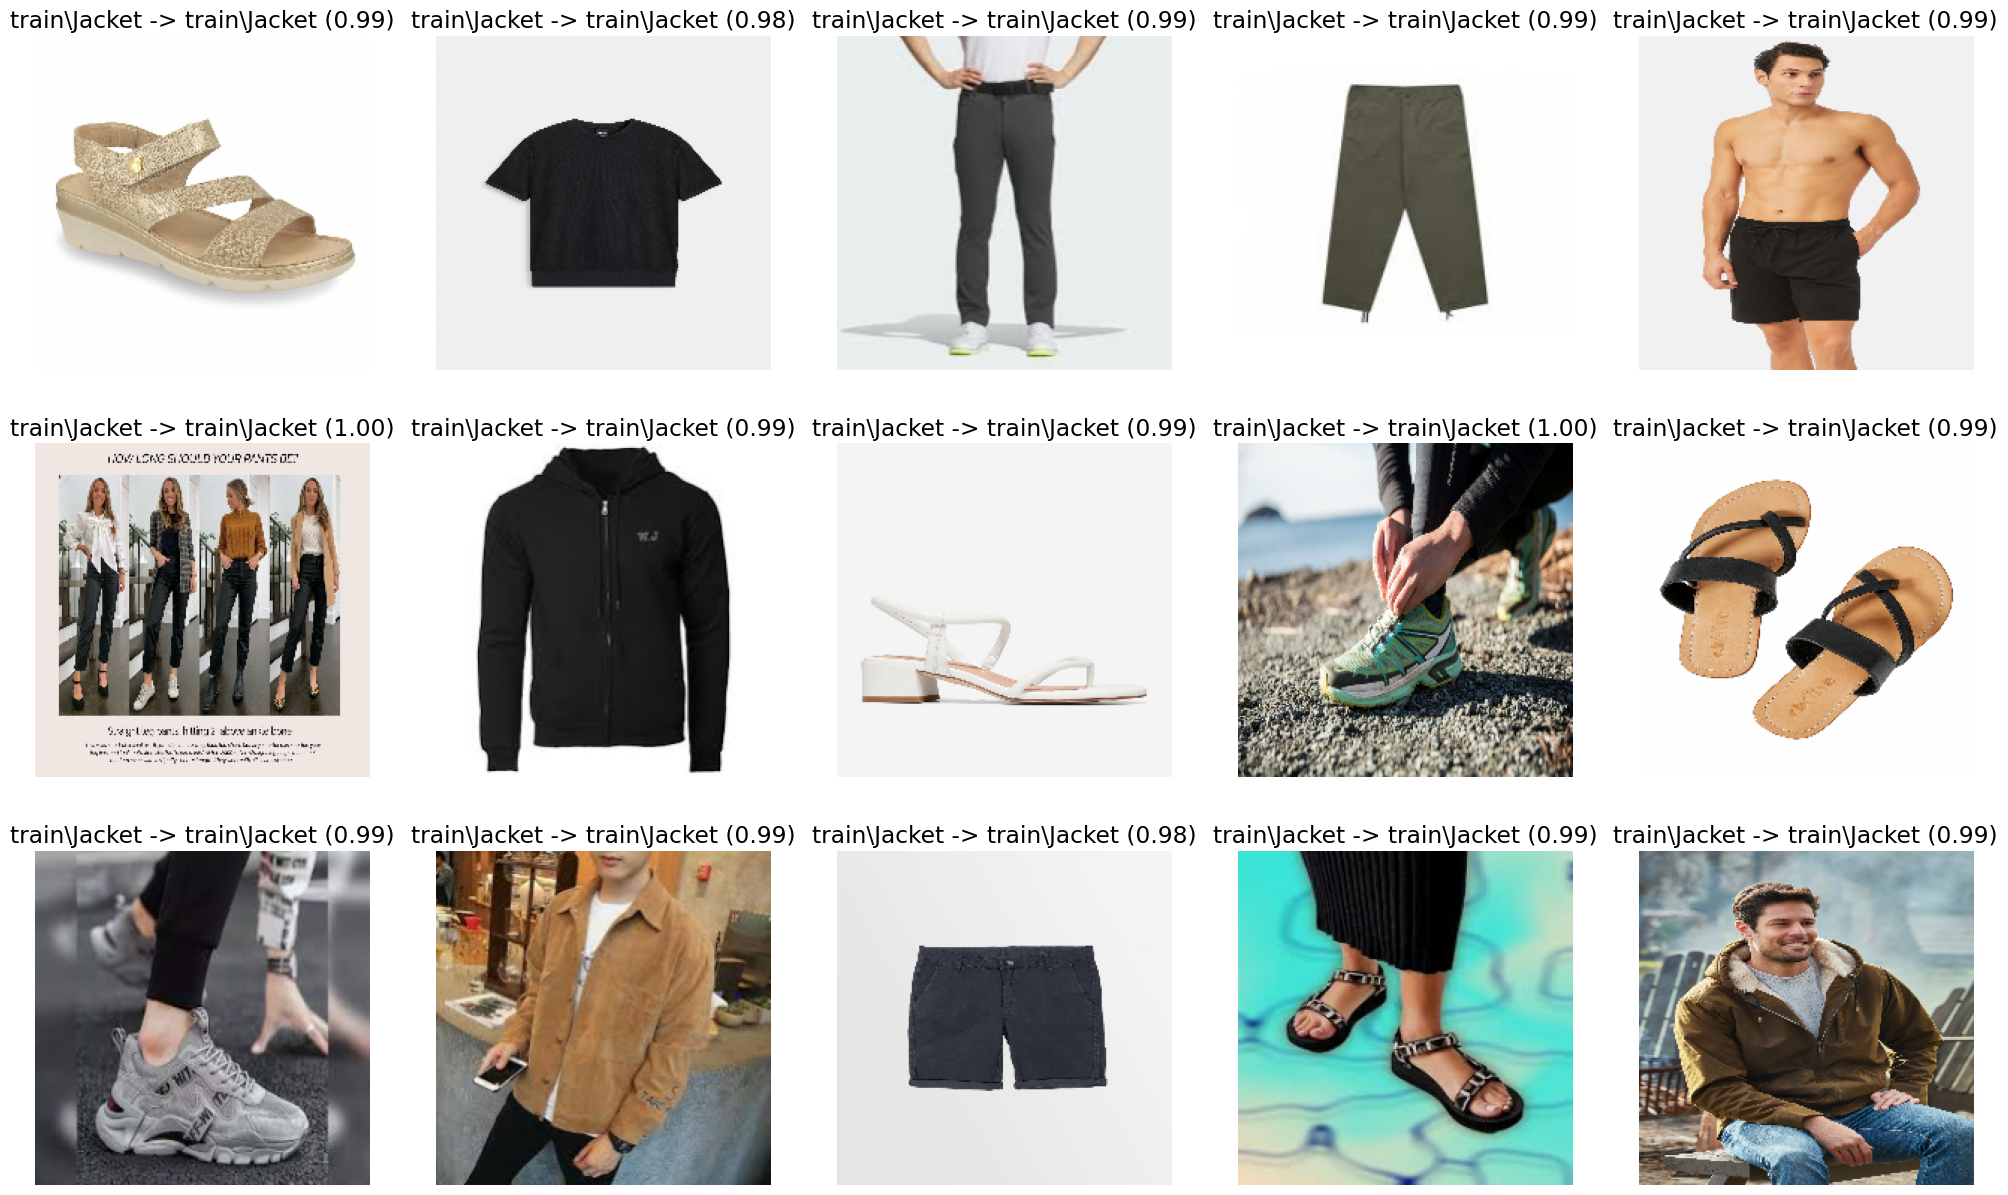

In [ ]:
def plot_predictions(filename):
  plt.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

plot_predictions("train.csv")

1/1 [==============================] - 0s 29ms/step


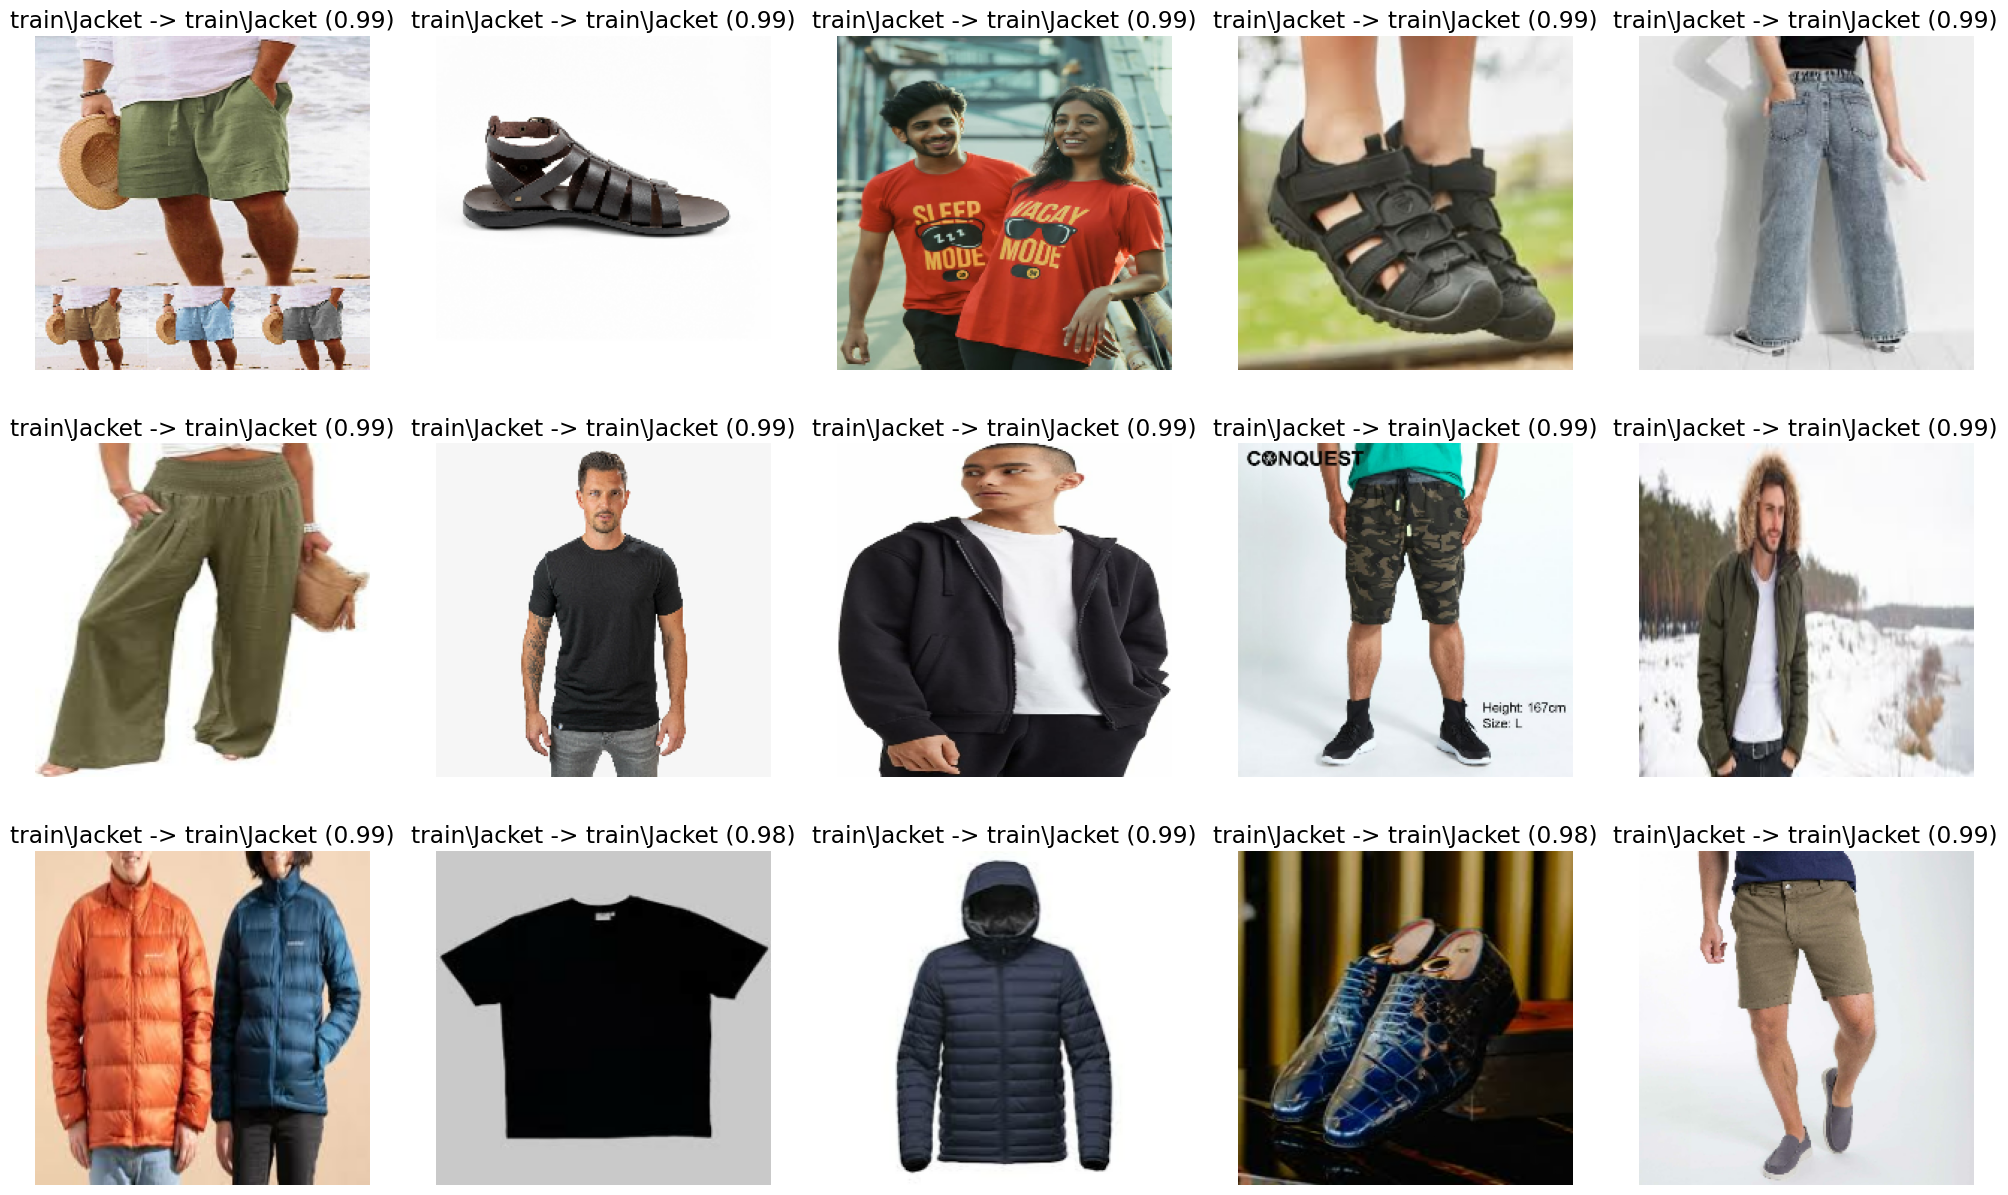

In [ ]:
plot_predictions("test.csv")

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.output_shape)


0 input_2 [(None, None, None, 3)]
1 conv1_pad (None, None, None, 3)
2 conv1_conv (None, None, None, 64)
3 conv1_bn (None, None, None, 64)
4 conv1_relu (None, None, None, 64)
5 pool1_pad (None, None, None, 64)
6 pool1_pool (None, None, None, 64)
7 conv2_block1_1_conv (None, None, None, 64)
8 conv2_block1_1_bn (None, None, None, 64)
9 conv2_block1_1_relu (None, None, None, 64)
10 conv2_block1_2_conv (None, None, None, 64)
11 conv2_block1_2_bn (None, None, None, 64)
12 conv2_block1_2_relu (None, None, None, 64)
13 conv2_block1_0_conv (None, None, None, 256)
14 conv2_block1_3_conv (None, None, None, 256)
15 conv2_block1_0_bn (None, None, None, 256)
16 conv2_block1_3_bn (None, None, None, 256)
17 conv2_block1_add (None, None, None, 256)
18 conv2_block1_out (None, None, None, 256)
19 conv2_block2_1_conv (None, None, None, 64)
20 conv2_block2_1_bn (None, None, None, 64)
21 conv2_block2_1_relu (None, None, None, 64)
22 conv2_block2_2_conv (None, None, None, 64)
23 conv2_block2_2_bn (None, None

In [ ]:
first_conv_layer = model.get_layer('conv1_conv')
print("Weights shape:", first_conv_layer.get_weights()[0].shape)  # Shows (kernel_height, kernel_width, input_channels, output_channels)

Weights shape: (7, 7, 3, 64)


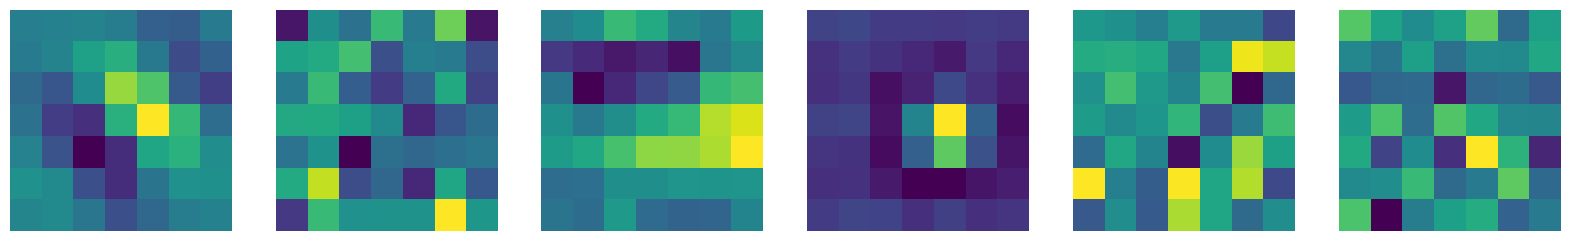

In [ ]:
def visualize_layer_weights(layer):
    weights = layer.get_weights()[0]  # Get the weights of the layer
    weights_min = np.min(weights)
    weights_max = np.max(weights)
    
    fig, axs = plt.subplots(1, 6, figsize=(20, 3))
    for i in range(6):  # Assuming you want to visualize the first 6 filters
        # Normalize the filter weights and reshape if necessary
        img = (weights[:, :, :, i] - weights_min) / (weights_max - weights_min)
        img = img.mean(axis=2)  # Convert to grayscale by averaging across color channels if needed
        axs[i].imshow(img, cmap='viridis')
        axs[i].axis('off')
    plt.show()

# Apply the function to the first convolutional layer
visualize_layer_weights(first_conv_layer)